<a href="https://colab.research.google.com/github/Chung-0218/Study/blob/main/Practice_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

## GPU 설정

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

## 데이터 로드 및 확인

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data -d .

--2021-05-31 06:38:15--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.203.52, 99.84.203.29, 99.84.203.35, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.203.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  93.2MB/s    in 0.5s    

2021-05-31 06:38:16 (93.2 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: ./hymenoptera_data/
   creating: ./hymenoptera_data/train/
   creating: ./hymenoptera_data/train/ants/
  inflating: ./hymenoptera_data/train/ants/0013035.jpg  
  inflating: ./hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: ./hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: ./hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: ./hym

## 전처리 설정

In [ ]:
data_transforms = {'train' : transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   'val' : transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [ ]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                 for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=4,
                             shuffle=True,
                             num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(class_names)

['ants', 'bees']


## 사전훈련된 모델 로드

In [ ]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [ ]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 모델 학습

- 학습 함수 정의

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6105 Acc: 0.7377
val Loss: 0.3664 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.5052 Acc: 0.8279
val Loss: 0.2355 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.7994 Acc: 0.7295
val Loss: 0.2396 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.7685 Acc: 0.7787
val Loss: 0.4256 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5305 Acc: 0.8238
val Loss: 0.5499 Acc: 0.8170

Epoch 5/24
----------
train Loss: 0.6950 Acc: 0.7500
val Loss: 0.3548 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.4172 Acc: 0.8197
val Loss: 0.2880 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4195 Acc: 0.8402
val Loss: 0.2170 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3598 Acc: 0.8443
val Loss: 0.2427 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.1955 Acc: 0.9098
val Loss: 0.2092 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2757 Acc: 0.8934
val Loss: 0.1964 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3607 Acc: 0.8402
val Loss: 0.2495 Acc: 0.8954

Epoch 12/24
----------
t

## 결과 시각화

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


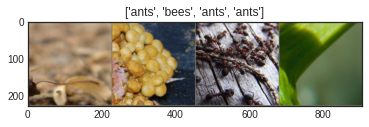

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

- 시각화 함수 정의

In [ ]:
def imshow(img):
  img = img / + 0.5
  npimg = plt.figure(figsize(10, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


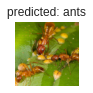

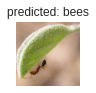

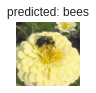

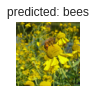

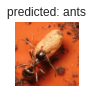

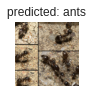

In [ ]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7121 Acc: 0.6066
val Loss: 0.2348 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4424 Acc: 0.7951
val Loss: 0.2031 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4222 Acc: 0.8115
val Loss: 0.1706 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.4414 Acc: 0.7951
val Loss: 0.3734 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.5713 Acc: 0.7623
val Loss: 0.4093 Acc: 0.8366

Epoch 5/24
----------
train Loss: 0.5964 Acc: 0.7336
val Loss: 0.2587 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3965 Acc: 0.8443
val Loss: 0.1497 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3194 Acc: 0.8689
val Loss: 0.1389 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4102 Acc: 0.8361
val Loss: 0.1865 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3361 Acc: 0.8525
val Loss: 0.1503 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3653 Acc: 0.8566
val Loss: 0.1492 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2698 Acc: 0.9016
val Loss: 0.1695 Acc: 0.9412

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


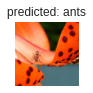

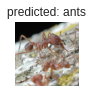

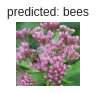

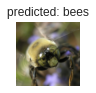

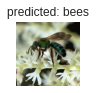

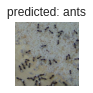

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()